In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
os.environ["TF_DISABLE_NVTX_RANGES"] = "1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["TF_XLA_FLAGS"] = "--tf_xla_cpu_global_jit"
os.environ["TF_GPU_THREAD_MODE"] = "gpu_private"
os.environ["TF_GPU_THREAD_COUNT"] = "40"
import logging
logger = logging.getLogger()
logger.setLevel(logging.WARN)

In [2]:
import time
import multiprocessing
from tqdm.notebook import tnrange, tqdm
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from common import cnn_models
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
USE_XLA = True
USE_AMP = True
LEARNING_RATE = 1e-3
IMG_SIZE = (224, 224)

In [4]:
def reset_session(xla, amp):
    try:
        del model
        del train
    except:
        pass
    tf.keras.backend.clear_session()
    tf.config.optimizer.set_jit(xla)
    tf.config.optimizer.set_experimental_options({"auto_mixed_precision": amp,
                                                  "debug_stripper": True,
                                                  "scoped_allocator_optimization": True,
                                                  "dependency_optimization": True})
    tf.config.threading.set_inter_op_parallelism_threads(40)

class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []
    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()
    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)


def return_base_dataset():
    dataset, info = tfds.load("imagenette/160px",
                          with_info=True,
                          as_supervised=True)
    num_class = 10
    
    @tf.function(experimental_compile=True)
    def format_example(image, label):
        image = tf.image.resize(image, IMG_SIZE)
        image = (image/127.5) - 1
        label = tf.one_hot(label, num_class)
        return image, label
    
    num_train = info.splits["train"].num_examples
    base = dataset["train"].shuffle(num_train)
    base = base.repeat(count=-1)
    base = base.map(format_example, num_parallel_calls=int(multiprocessing.cpu_count()-1))
    _ = str(base.take(1))
    return base, num_class

def return_batched_dataset(base, batch_size):
    train = base.batch(batch_size, drop_remainder=True)
    train = train.prefetch(64)
    _ = str(train.take(1))
    return train

def rn50(img_size=(224,224), num_class=2, weights="imagenet"):
    model = cnn_models.rn50(img_size, num_class)
    return model

def return_model(num_class=8):
    model = rn50(IMG_SIZE, num_class)
    opt = tf.keras.optimizers.SGD(lr=LEARNING_RATE)
    model.compile(loss="categorical_crossentropy",
                  optimizer=opt)
    return model

def sample_train(batch_size, train, model, steps=30):
    time_history = TimeHistory()
    model.fit(train, steps_per_epoch=steps, verbose=0,
              epochs=3, callbacks=[time_history])
    duration = min(time_history.times)
    batch_time = duration/steps
    fps = int(steps*batch_size/duration)
    return batch_time, fps

In [5]:
power_of_two = [2**i for i in range(1, 9)]
mult_of_eight = [8*i for i in range(1, 41)]
sm_count = 80
mult_of_sm = [sm_count*i for i in range(1, 4)]

test_range = list(set([1] + power_of_two + mult_of_eight + mult_of_sm))
test_range.sort(reverse=True)
    
print("Test range:", len(test_range))
print(test_range)

Test range: 43
[320, 312, 304, 296, 288, 280, 272, 264, 256, 248, 240, 232, 224, 216, 208, 200, 192, 184, 176, 168, 160, 152, 144, 136, 128, 120, 112, 104, 96, 88, 80, 72, 64, 56, 48, 40, 32, 24, 16, 8, 4, 2, 1]


In [6]:
bs_list, bt_list, fps_list = [], [], []

reset_session(True, True)
strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
with strategy.scope():
    base, num_class = return_base_dataset()
    model = return_model(num_class=num_class)

for bs in tqdm(test_range):
    with strategy.scope():
        train = return_batched_dataset(base, bs)
        batch_time, fps = sample_train(bs, train, model)
    print(bs, fps)
    bs_list.append(bs)
    fps_list.append(fps)
    bt_list.append(batch_time)

320 1582
312 1587
304 1571
296 1580
288 1563
280 1571
272 1578
264 1570
256 1578
248 1559
240 1546
232 1542
224 1534
216 1515
208 1544
200 1534
192 1530
184 1503
176 1488
168 1485
160 1445
152 1454
144 1432
136 1411
128 1408
120 1380
112 1348
104 1359
96 1327
88 1289
80 1252
72 1221
64 1180
56 1124
48 1085
40 984
32 871
24 663
16 495
8 250
4 122
2 63
1 31



In [7]:
lbs_list, lbt_list, lfps_list = [], [], []

del model

reset_session(False, False)
strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
with strategy.scope():
    base, num_class = return_base_dataset()
    model = return_model(num_class=num_class)

for bs in tqdm(test_range):
    try:
        with strategy.scope():
            train = return_batched_dataset(base, bs)
            batch_time, fps = sample_train(bs, train, model)
        print(bs, fps)
        lbs_list.append(bs)
        lfps_list.append(fps)
        lbt_list.append(batch_time)
    except:
        pass

216 432
208 441
200 438
192 439
184 435
176 435
168 430
160 431
152 432
144 431
136 426
128 427
120 416
112 416
104 422
96 419
88 408
80 401
72 400
64 394
56 382
48 382
40 361
32 351
24 334
16 300
8 213
4 120
2 77
1 35



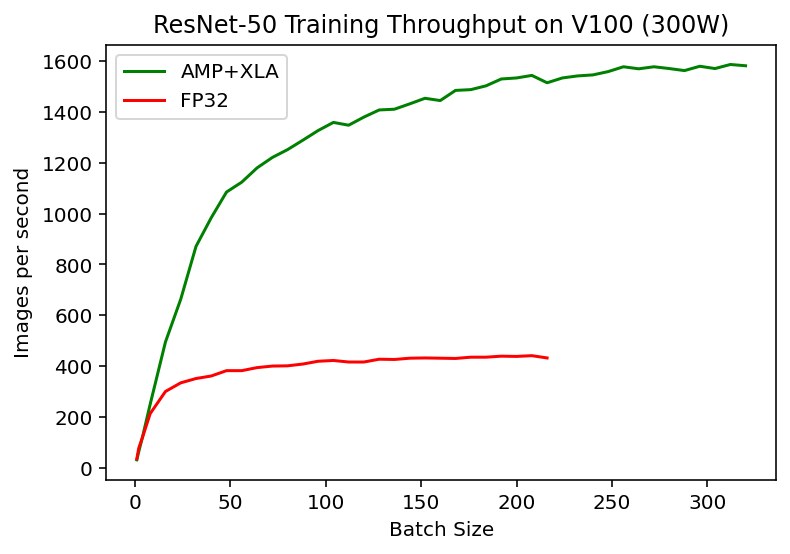

In [8]:
plt.title("ResNet-50 Training Throughput on V100 (300W)")
plt.plot(bs_list, fps_list, label="AMP+XLA", color="g")
plt.plot(lbs_list, lfps_list, label="FP32", color="r")
#plt.axvline(80, c="k", linestyle="--", linewidth=1, label="SM count")
plt.xlabel("Batch Size")
plt.ylabel("Images per second")
plt.legend()
plt.show()

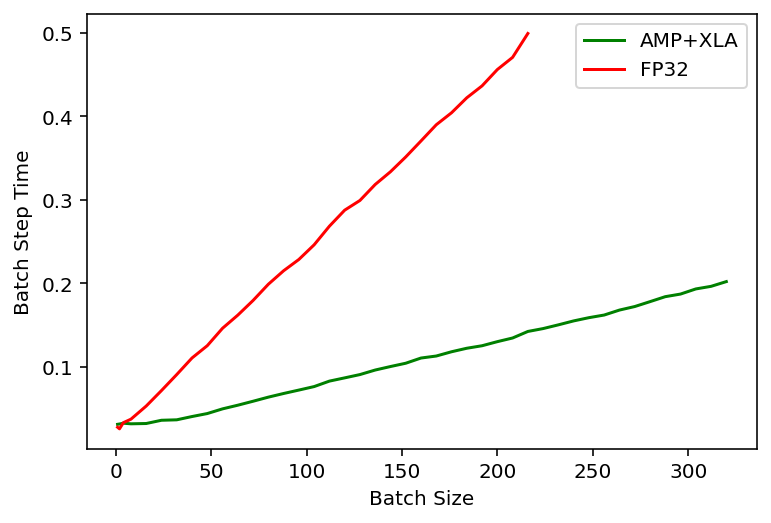

In [9]:
plt.plot(bs_list, bt_list, label="AMP+XLA", color="g")
plt.plot(lbs_list, lbt_list, label="FP32", color="r")
plt.xlabel("Batch Size")
plt.ylabel("Batch Step Time")
plt.legend()
plt.show()

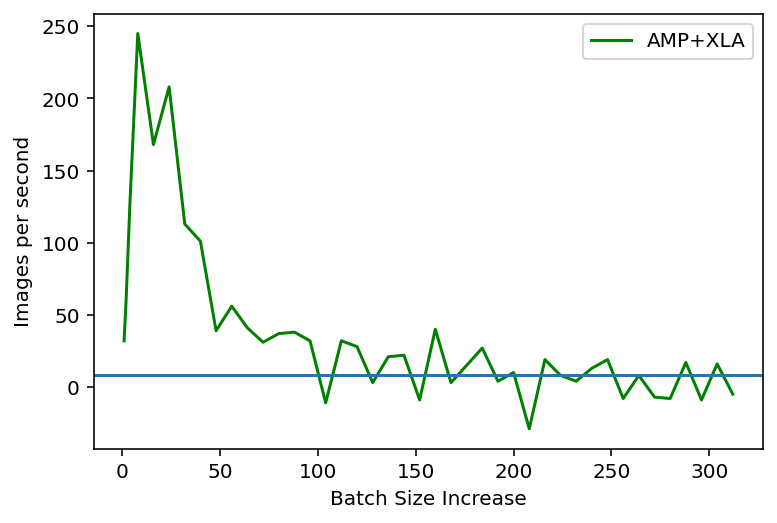

In [10]:
diff = np.asarray(fps_list[:-1]) - np.asarray(fps_list[1:])
plt.plot(bs_list[1:], diff, label="AMP+XLA", color="g")
plt.axhline(8)
plt.xlabel("Batch Size Increase")
plt.ylabel("Images per second")
plt.legend()
plt.show()